In [386]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification, make_gaussian_quantiles
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.python.ops import math_ops

In [387]:
PROJECT_HOME = '../../'
VIS_PATH = PROJECT_HOME+'vis/'

In [425]:
def get_two_class_data(shape, n=100, std=0.05, seed=None):    
    if shape=='moons':
        return make_moons(n_samples=n, noise=std, random_state=seed)
    elif shape=='circles':
        return make_circles(n_samples=n, noise=std, random_state=seed)
    else:
        raise ValueError("Shape must be either 'moons' or 'circles'")

def get_multi_class_data(shape, n_classes=3, n_samples=100, seed=None):
    if shape=='normal':
        return make_classification(n_samples=n_samples,
                                   n_features=2, 
                                   n_redundant=0, 
                                   n_clusters_per_class=1, 
                                   n_classes=n_classes,
                                   random_state=seed)
    if shape=='quantiles':
        return make_gaussian_quantiles(n_samples=n_samples,
                                       n_classes=n_classes,
                                       random_state=seed)
        
X, y = get_multi_class_data('quantiles', n_samples=400, n_classes=4, seed=574)
X, X_t, y, y_t = train_test_split(X, y, test_size=0.4, random_state=133)
X.shape

(240, 2)

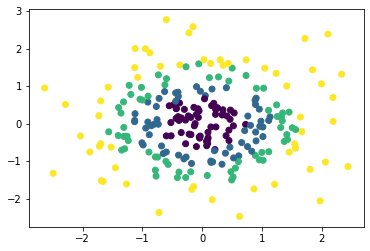

In [426]:
plt.scatter(X[:,0], X[:,1], c=y)

## Possible approaches

1. Use a label $R_{t}$ that'll be used in the loss
    - Problem: what is $R_{t}$ for classes? Metric in input space is uninformative
2. Always feed two examples of one class, and counter example of different class

We will start with **approach 2**: Each element in `data` will contain 3 elements, each of which is a coordinate represented as 2-D array. The first 2 elements belong to the same class, while the last element is of a different class.

In [427]:
# In the dataset, one datapoint should be a triplet of tuples representing coordinates
def createTripletData(X, y):
    data = []
    # for each class
    labels = np.unique(y)
    for label in labels:
        elems = X[np.argwhere(y==label)][:,0,:][:50]
        print(elems.shape)
        # for all combinations of elems in that class
        for xi, xj in combinations(elems, 2):
            # combine with every element from other class(es)
            for cont_elem in X[np.argwhere(y!=label)][:,0,:]:
                data.append([xi, xj, cont_elem])
    return np.array(data)

data = createTripletData(X, y)
np.random.shuffle(data)
data = np.transpose(data, (1,0,2))
data.shape

(50, 2)
(50, 2)
(50, 2)
(50, 2)


(3, 882000, 2)

## Create Model

In [444]:
n_out_nodes = 1

def create_base_network(inp_shape):
    inp = keras.Input(shape=2)
    hidden = layers.Dense(20, 'relu')(inp)
    out = layers.Dense(n_out_nodes, 'linear')(hidden)
    return keras.Model(inp, out)

emb = create_base_network(inp_shape=2) # output_shape : (None, 2)

ins = [keras.Input(shape=2, name=str(i)) for i in range(3)]
x = [emb(ins[i]) for i in range(3)]
x = layers.Concatenate()(x) # (None, 6)
x = layers.Reshape((3,n_out_nodes))(x) # (None, 3, 2)

model = keras.Model(ins, x)
print(model.input_shape, model.output_shape)
# Input shape : (3, None, 2)
# Output shape : (None, 3, 2)

[(None, 2), (None, 2), (None, 2)] (None, 3, 1)


In [445]:
class SimilarityLoss(keras.losses.Loss):
    def __init__(self, gamma, beta, alpha,
                 reduction=keras.losses.Reduction.AUTO,
                 name='custom_similarity'):
        super().__init__(reduction=reduction, name=name)
        self.gamma = gamma,
        self.beta  = beta,
        self.alpha = alpha
    
    def __call__(self, pred):
        p0 = pred[:,0,:]
        p1 = pred[:,1,:]
        p2 = pred[:,2,:]
        d1 = K.square(tf.norm(p1-p0, ord='euclidean', axis=1))
        d2 = K.square(tf.norm(p2-p0, ord='euclidean', axis=1))
        return K.maximum(0, self.gamma*d1 - self.beta*d2 + self.alpha)
    
similarity_loss = SimilarityLoss(gamma=1, beta=0.5, alpha=1)

In [446]:
optimizer = tf.keras.optimizers.Adam()
loss_history = []
bs = 64

def train_step(batch):
    with tf.GradientTape() as tape:
        logits = model(batch, training=True)
        # Add asserts to check the shape of the output.
        #tf.debugging.assert_equal(logits.shape, (n, 6))
        loss_value = similarity_loss(logits)
        mean_loss = loss_value.numpy().mean()
    loss_history.append(mean_loss)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return mean_loss

def train(epochs):
    for epoch in range(1,epochs+1):
        print('== Epoch {} =='.format(epoch))
        step = 0
        for i in range(0, len(data[0]), bs):
            batch = [data[0,i:i+bs,:],data[1,i:i+bs,:],data[2,i:i+bs,:]]
            loss_value = train_step(batch)
            step += 1
            if step % 200 == 0:
                print('Training loss at step {}: {}'.format(step, float(loss_value)))
            if step % 10000 == 0:
                break
                
train(2)

== Epoch 1 ==
Training loss at step 200: 0.49737557768821716
Training loss at step 400: 0.31127187609672546
Training loss at step 600: 0.5683480501174927
Training loss at step 800: 0.2802170217037201
Training loss at step 1000: 0.3587278723716736
Training loss at step 1200: 0.27415648102760315
Training loss at step 1400: 0.2856094539165497
Training loss at step 1600: 0.41370004415512085
Training loss at step 1800: 0.15649230778217316
Training loss at step 2000: 0.21935725212097168
Training loss at step 2200: 0.3110433518886566
Training loss at step 2400: 0.2709098756313324
Training loss at step 2600: 0.2837364077568054
Training loss at step 2800: 0.4754769504070282
Training loss at step 3000: 0.3064577281475067
Training loss at step 3200: 0.20749899744987488
Training loss at step 3400: 0.20283961296081543
Training loss at step 3600: 0.27242809534072876
Training loss at step 3800: 0.396756112575531
Training loss at step 4000: 0.2868247330188751
Training loss at step 4200: 0.261396765708

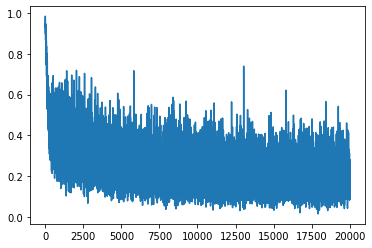

In [447]:
plt.plot(loss_history)
#plt.savefig(VIS_PATH+'400_loss_history')

## Check learned representations

In [448]:
def get_projection(dp):
    return list(model([np.array([dp]),np.array([[0,0]]),np.array([[0,0]])]).numpy()[0,0])

# Test on unseen data
Y_Hat = np.array([get_projection(dp) for dp in X_t])

if model.output_shape[-1] == 1:
    axarr = np.array([[0.]]*Y_Hat.shape[0])
    Y_Hat = np.concatenate((Y_Hat, axarr), axis = 1)
    print('Extended 1-D projections for plotting.')

Extended 1-D projections for plotting.


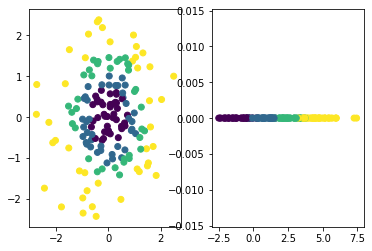

In [449]:
fig, ax = plt.subplots(1,2)
#ax[0].axis('off')
ax[0].scatter(X_t[:,0], X_t[:,1], c=y_t)
#ax[1].axis('off')
ax[1].scatter(Y_Hat[:,0], Y_Hat[:,1], c=y_t)
#plt.savefig(VIS_PATH+'400_init3')
plt.show()